# FLOWER RECOGNITION: 
## DIFFERENT APPROACHES TO IMAGE CLASSIFICATION

### 1. Loading and preparing the data

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
import time

First I will load a single image and see to start visualy exploring the data without burdening the computer with the whole dataset at once. 

I will try to reduce image size and see if it is clear enough for the model to recognize them. It's important to not have images that are too big, but if we reduce too much the quality they will become too blurry to be of any use. 
For example, if we try with a size of 50, it is way too much reduction, but with 100x100 seems to be enough.

Anyway, the decision about the image size it's not yet definitive and might be subject to some fine tuning later in the process. 

* EDIT: accuracy model with 100x100 was very low, so I'll try to increase the size a little bit to see if it improves

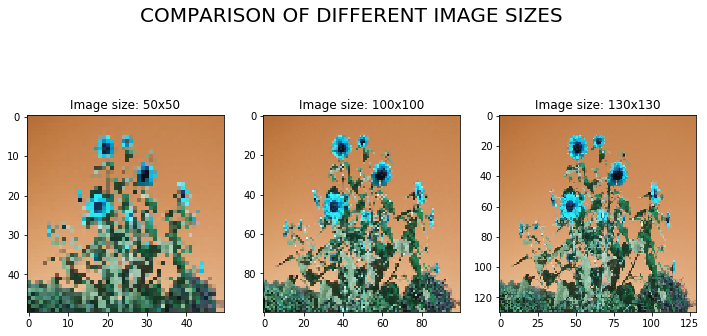

In [18]:
path = "data/Train/sunflower/"
photo = "1788133737_b1133d1aa7.jpg" #just select manually an image to avoid problems with exceptions 

f, ax = plt.subplots(1, 3, figsize = (12, 6))
f.suptitle("COMPARISON OF DIFFERENT IMAGE SIZES", fontsize = 20)
ax[0].imshow(cv2.resize(cv2.imread(path + photo), (50, 50)))
ax[0].set_title("Image size: 50x50")
ax[1].imshow(cv2.resize(cv2.imread(path + photo), (100, 100)))
ax[1].set_title("Image size: 100x100")
ax[2].imshow(cv2.resize(cv2.imread(path + photo), (130, 130)))
ax[2].set_title("Image size: 130x130")
plt.show()

#### 1.1. Creating a training dataset

Once we have decided what seems a good size for pictures, we will proceed to create the training and testing data separation. For this step, I won't follow a very scientific approach. I simply went into the different folders and moved the first 80 observations into the testing data. This represent about the 70% of the observations, although there are differents among flowers since some of them have more observations than others. After this split has been already done, now we can proceed with the creation of our training dataset (~4000 total observations). To do so, I'll create a function using the structure that I showed in the beginning of the notebook. 

In [32]:
pic_size = 100
training = []
directory = "data/Train"
categories = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
def create_dataset():
    for category in categories:
        path = os.path.join(directory, category) #Iterate through everyone of the different folders
        class_index = categories.index(category)  #get numerical indexes for the categories of flower

        for pic in os.listdir(path):
            try:
                pic_array = cv2.imread(os.path.join(path,pic)) #create an array for every image
                new_array = cv2.resize(pic_array, (pic_size, pic_size)) #change the size of the image
                training.append([new_array, class_index])  # append every image to the training data frame
            except Exception as e:  
                pass
create_dataset() 


#### 1.2. Shuffling the data

In [33]:
for i in training[:10]:
    print(i[1])

0
0
0
0
0
0
0
0
0
0


Given the way our function is been created, the training will take place sequentially by categories. That is, first all daisies, then all dandelions, etc. This is a suboptimal way of learning.

To counter this, we will shuffle all the observations in our data set so that they appear in a more mixed way and not one after the other. To do this, we need to use the "shuffle" function inside the "random" package.

In [34]:
random.shuffle(training)

In [35]:
for i in training[:10]: # Take the first 10 observations
    print(i[1]) # Print only the label column

2
2
4
3
3
1
1
1
2
2


Now it can be observed that the data it has actually been shuffled.

#### 1.3. Final pre-processing

In order to facilitate the process of inputing data into our models, let's separate our data set into two different lists with dependent and independent variables respectively. 

In [36]:
x = []
y = []

for dependent, independent in training:
    x.append(dependent)
    y.append(independent)

Finally, transform the lists into arrays so that it is easier to normalize the data for our model. More complex techniques such as the tf.keras.utils.normalize. However, given our context and for the sake of simplicity I will stick to use min-max scale of the data. Given that we're operating with image data (min = 0 and max = 255) we have only to divide by 255. 

In [37]:
x = np.asarray(x)
y = np.asarray(y)
        

In [38]:
# scaling formula: scaled x = (xi - minimum) / (Maximum - minimum ) where max is 255 and min is 0

x = x / 255.0

### 2. Model creation: Convolutional Neural Network

Let's start by preparing the labels to be used in the tensorflow model.

In [40]:
number_of_categories = 5

y_categories = to_categorical(y, number_of_categories)

It is complicated to decide beforehand what are the best parameters for our model so we're going to try several combinations and try to decide which gives better results for our validation set:
* Test different sizes for the dense layer: 32, 64 and 128
* Test different layer sizes for the convolutional layer

In [62]:
dense_layer_size = [32, 64, 128]
convolutional_layer_size = [32, 64, 128]

for layer_size in convolutional_layer_size : 
    for dense_ls in dense_layer_size :
        model_name = "flower-recognition-cnn-{}-x2-{}-dense-{}-".format(layer_size, dense_ls, int(time.time()))
        print(model_name)
        
        model = Sequential() #defining the type of model

        #first layer
        model.add(Conv2D(layer_size, (3, 3), input_shape = (100, 100, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # second layer
        model.add(Conv2D(layer_size, (3, 3)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())  # flatten the dataset to be able to pass it to the dense layer

        # dense layer
        model.add(Dense(dense_ls,activation='relu'))
        model.add(Activation("relu"))


        model.add(Dense(5))
        model.add(Activation('softmax'))
        
        tensor_board = TensorBoard(log_dir = "logs/{}".format(model_name))

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.fit(x, y_categories, batch_size = 30, epochs = 5, validation_split = 0.1, callbacks = [tensor_board])


        

flower-recognition-cnn-32-x2-32-dense-1553094732-
Train on 3530 samples, validate on 393 samples
Epoch 1/5
3530/3530 [==============================] - 42s 12ms/sample - loss: 0.4213 - acc: 0.8137 - val_loss: 0.3983 - val_acc: 0.8254
Epoch 2/5
3530/3530 [==============================] - 44s 12ms/sample - loss: 0.3522 - acc: 0.8499 - val_loss: 0.3712 - val_acc: 0.8422
Epoch 3/5
3530/3530 [==============================] - 49s 14ms/sample - loss: 0.2959 - acc: 0.8762 - val_loss: 0.3662 - val_acc: 0.8534
Epoch 4/5
3530/3530 [==============================] - 49s 14ms/sample - loss: 0.2465 - acc: 0.9007 - val_loss: 0.3393 - val_acc: 0.8601
Epoch 5/5
3530/3530 [==============================] - 46s 13ms/sample - loss: 0.1939 - acc: 0.9237 - val_loss: 0.3768 - val_acc: 0.8580
flower-recognition-cnn-32-x2-64-dense-1553094968-
Train on 3530 samples, validate on 393 samples
Epoch 1/5
3530/3530 [==============================] - 53s 15ms/sample - loss: 0.4794 - acc: 0.7988 - val_loss: 0.4391 - 

As we can see in the picture below, so far the best model it's the one with:
* 2 convolutional layers of 128 nodes
* 1 dense layer of 32 nodes

However, to reach this conclusion I have arbitrarily decided to use this number of each type of layer. A better way of doing it would be to use a similar approach with for loops in order to determine the best possible number of layers.

Another interesting thing to test, would be if the model improves with convolutional layers of 256 nodes. Since so far it seems to get better when we augment the layer size. 

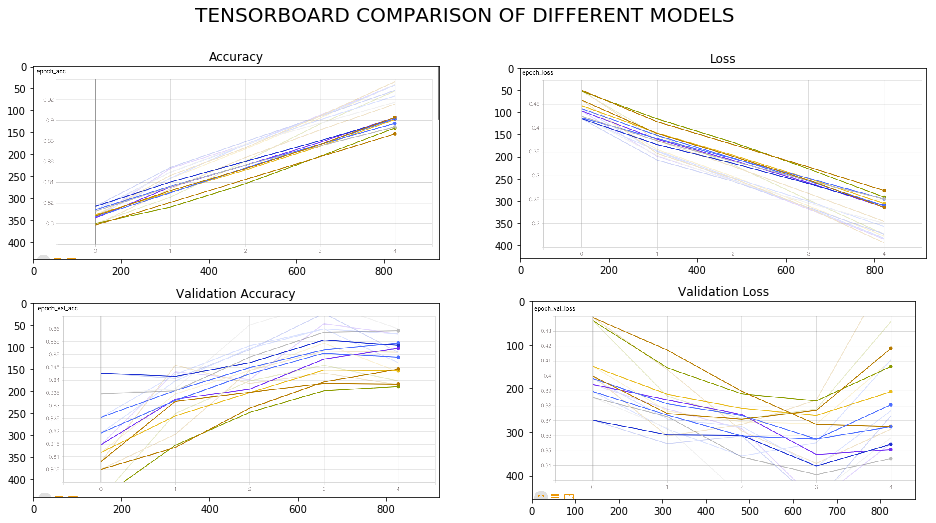

In [71]:
path = "logs/"
accuracy = "accuracy.jpg"
loss = "loss.jpg"
validation_accuracy = "validation_acc.jpg"
validation_loss = "val_loss.jpg"

f, ax = plt.subplots(2, 2, figsize = (16, 8))
f.suptitle("TENSORBOARD COMPARISON OF DIFFERENT MODELS", fontsize = 20)
ax[0,0].imshow(cv2.imread(path + accuracy))
ax[0,0].set_title("Accuracy")
ax[0,1].imshow(cv2.imread(path + loss))
ax[0,1].set_title("Loss")
ax[1,0].imshow(cv2.imread(path + validation_accuracy))
ax[1,0].set_title("Validation Accuracy")
ax[1,1].imshow(cv2.imread(path + validation_loss))
ax[1,1].set_title("Validation Loss")
plt.show()

### 3. Testing the model

Using the images that had been previously separated, let's build a testing dataset to check the performance of the model. To do so, I'll repeat the steps we carried out to build the train data set so I won't go into much detail this time.

In [79]:
pic_size = 100
testing = []
directory = "data/Test"
categories = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
def create_test():
    for category in categories:
        path = os.path.join(directory, category) #Iterate through everyone of the different folders
        class_index = categories.index(category)  #get numerical indexes for the categories of flower

        for pic in os.listdir(path):
            try:
                pic_array = cv2.imread(os.path.join(path,pic)) #create an array for every image
                new_array = cv2.resize(pic_array, (pic_size, pic_size)) #change the size of the image
                testing.append([new_array, class_index])  # append every image to the training data frame
            except Exception as e:  
                pass
create_test() 

# separate into dependent and independent variables 
test_x = []
test_y = []

for dependent, independent in testing:
    test_x.append(dependent)
    test_y.append(independent)
    
test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

# scaling formula: scaled x = (xi - minimum) / (Maximum - minimum ) where max is 255 and min is 0

test_x = test_x / 255.0

number_of_categories = 5

y_test_categories = to_categorical(test_y, number_of_categories)
        

Now, let's run the previously chosen model and use the test dataset as validation_data to see how well our model performs. 

In [85]:
model_name = "flower-recognition-cnn-128-x2-32-dense-{}-".format(layer_size, dense_ls, int(time.time()))

model = Sequential() #defining the type of model

#first layer
model.add(Conv2D(128, (3, 3), input_shape = (100, 100, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second layer
model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # flatten the dataset to be able to pass it to the dense layer

# dense layer
model.add(Dense(32,activation='relu'))
model.add(Activation("relu"))


model.add(Dense(5))
model.add(Activation('softmax'))

tensor_board = TensorBoard(log_dir = "logs/{}".format(model_name))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x, y_categories, batch_size = 30, epochs = 5, validation_data = (test_x, y_test_categories))

model.save("cnn-128x2-32-dense.model")


Train on 3923 samples, validate on 400 samples
Epoch 1/5
3923/3923 [==============================] - 851s 217ms/sample - loss: 0.4386 - acc: 0.8086 - val_loss: 0.3758 - val_acc: 0.8345
Epoch 2/5
3923/3923 [==============================] - 485s 124ms/sample - loss: 0.3511 - acc: 0.8445 - val_loss: 0.3216 - val_acc: 0.8645
Epoch 3/5
3923/3923 [==============================] - 362s 92ms/sample - loss: 0.2981 - acc: 0.8751 - val_loss: 0.3098 - val_acc: 0.8630
Epoch 4/5
3923/3923 [==============================] - 382s 97ms/sample - loss: 0.2565 - acc: 0.8942 - val_loss: 0.3531 - val_acc: 0.8535
Epoch 5/5
3923/3923 [==============================] - 314s 80ms/sample - loss: 0.2081 - acc: 0.9191 - val_loss: 0.3227 - val_acc: 0.8725


Finally, before considering this project as finished, let's visually observe for a small sample how the model is predicting the classes. As it is seen, it appears that the model is doing quite well for most categories.

In [101]:
prediction = model.predict_classes(test_x)
prediction_sample = prediction[::10] #Take some images from different categories from the test dataset
test_y_sample = test_y[::10] #Take the corresponding labels for the images we selected

for i in range(len(prediction_sample)):
    print(prediction_sample[i],'==>',test_y_sample[i])

3 ==> 0
0 ==> 0
0 ==> 0
0 ==> 0
0 ==> 0
0 ==> 0
0 ==> 0
3 ==> 0
1 ==> 1
1 ==> 1
1 ==> 1
1 ==> 1
3 ==> 1
1 ==> 1
0 ==> 1
0 ==> 1
2 ==> 2
3 ==> 2
2 ==> 2
2 ==> 2
2 ==> 2
2 ==> 2
2 ==> 2
2 ==> 2
3 ==> 3
3 ==> 3
3 ==> 3
3 ==> 3
3 ==> 3
2 ==> 3
3 ==> 3
3 ==> 3
2 ==> 4
4 ==> 4
4 ==> 4
4 ==> 4
4 ==> 4
2 ==> 4
4 ==> 4
4 ==> 4
